In [1]:
import sys
path = r"/Users/constantinslioussarenko/PythonGitRepositories/MyoMap"
#path = r"/home/cslioussarenko/PythonRepositories"
sys.path.append(path+"/epgpy")
sys.path.append(path+"/machines")
sys.path.append(path+"/mutools")
sys.path.append(path+"/dicomstack")
sys.path.append(path+"/mrf-sim")

#import matplotlib
#matplotlib.u<se("TkAgg")
from mrfsim import T1MRF
from image_series import *
from dictoptimizers import SimpleDictSearch
from utils_mrf import *
import json
import readTwix as rT
import time
import os
from numpy.lib.format import open_memmap
from numpy import memmap
import pickle
from scipy.io import loadmat,savemat
import twixtools
from mutools import io
%matplotlib inline
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

I was here


In [2]:
base_folder = "../data/InVivo/3D"
localfile="/phantom.001.v1/phantom.001.v1.dat"


In [3]:

filename = base_folder+localfile

filename_save=str.split(filename,".dat") [0]+".npy"
#filename_nav_save=str.split(base_folder+"/phantom.001.v1/phantom.001.v1.dat",".dat") [0]+"_nav.npy"
filename_nav_save=str.split(filename,".dat") [0]+"_nav.npy"



folder = "/".join(str.split(filename,"/")[:-1])

suffix="_allspokes8"

filename_b1 = str.split(filename,".dat") [0]+"_b1{}.npy".format("")
filename_seqParams = str.split(filename,".dat") [0]+"_seqParams.pkl"

filename_volume = str.split(filename,".dat") [0]+"_volumes{}.npy".format(suffix)
filename_volume_corrected = str.split(filename,".dat") [0]+"_volumes_corrected{}.npy".format(suffix)
filename_kdata = str.split(filename,".dat") [0]+"_kdata{}.npy".format("")
filename_mask= str.split(filename,".dat") [0]+"_mask{}.npy".format("")
filename_oop=str.split(filename,".dat") [0]+"_volumes_oop{}.npy".format(suffix)
filename_oop_corrected=str.split(filename,".dat") [0]+"_volumes_oop_corrected{}.npy".format(suffix)


In [4]:

density_adj_radial=True
use_GPU = True
light_memory_usage=True
#Parsed_File = rT.map_VBVD(filename)
#idx_ok = rT.detect_TwixImg(Parsed_File)
#RawData = Parsed_File[str(idx_ok)]["image"].readImage()

if str.split(filename_seqParams,"/")[-1] not in os.listdir(folder):

    twix = twixtools.read_twix(filename,optional_additional_maps=["sWipMemBlock","sKSpace"],optional_additional_arrays=["SliceThickness"])

    if np.max(np.argwhere(np.array(twix[-1]["hdr"]["Meas"]["sWipMemBlock"]["alFree"])>0))>=16:
        use_navigator_dll = True
    else:
        use_navigator_dll = False



    alFree = twix[-1]["hdr"]["Meas"]["sWipMemBlock"]["alFree"]
    x_FOV = twix[-1]["hdr"]["Meas"]["RoFOV"]
    y_FOV = twix[-1]["hdr"]["Meas"]["PeFOV"]
    z_FOV = twix[-1]["hdr"]["Meas"]["SliceThickness"][0]

    nb_part = twix[-1]["hdr"]["Meas"]["Partitions"]

    dico_seqParams = {"alFree":alFree,"x_FOV":x_FOV,"y_FOV":y_FOV,"z_FOV":z_FOV,"use_navigator_dll":use_navigator_dll,"nb_part":nb_part}

    del alFree

    file = open(filename_seqParams, "wb")
    pickle.dump(dico_seqParams, file)
    file.close()

else:
    file = open(filename_seqParams, "rb")
    dico_seqParams = pickle.load(file)
    file.close()



try:
    del twix
except:
    pass


use_navigator_dll=dico_seqParams["use_navigator_dll"]

if use_navigator_dll:
    meas_sampling_mode=dico_seqParams["alFree"][14]
    nb_gating_spokes = dico_seqParams["alFree"][6]
else:
    meas_sampling_mode = dico_seqParams["alFree"][12]
    nb_gating_spokes = 0

if nb_gating_spokes>0:
    meas_orientation =  dico_seqParams["alFree"][11]
    if meas_orientation==1:
        nav_direction = "READ"
    elif meas_orientation==2:
        nav_direction = "PHASE"
    elif meas_orientation==3:
        nav_direction = "SLICE"

nb_segments = dico_seqParams["alFree"][4]

x_FOV = dico_seqParams["x_FOV"]
y_FOV = dico_seqParams["y_FOV"]
z_FOV = dico_seqParams["z_FOV"]
nb_part = dico_seqParams["nb_part"]

del dico_seqParams

if meas_sampling_mode==1:
    incoherent=False
    mode = None
elif meas_sampling_mode==2:
    incoherent = True
    mode = "old"
elif meas_sampling_mode==3:
    incoherent = True
    mode = "new"




if str.split(filename_save,"/")[-1] not in os.listdir(folder):
    if 'twix' not in locals():
        print("Re-loading raw data")
        twix = twixtools.read_twix(filename)

    mdb_list = twix[-1]['mdb']
    if nb_gating_spokes > 0:
        print("Reading Navigator Data....")
        data_for_nav = []
        k = 0
        for i, mdb in enumerate(mdb_list):
            if mdb.is_image_scan() and mdb.mdh[14][9]:
                data_for_nav.append(mdb)

                #print("i : {} / k : {} / Line : {} / Part : {}".format(i, k, mdb.cLin, mdb.cPar))
                k += 1
        data_for_nav = np.array([mdb.data for mdb in data_for_nav])
        data_for_nav = data_for_nav.reshape((int(nb_part),int(nb_gating_spokes))+data_for_nav.shape[1:])

        if data_for_nav.ndim==3:
            data_for_nav=np.expand_dims(data_for_nav,axis=-2)

        data_for_nav = np.moveaxis(data_for_nav,-2,0)
        np.save(filename_nav_save, data_for_nav)

    del mdb_list

    ##################################################
    mapped = twixtools.map_twix(twix)
    try:
        del twix
    except:
        pass
    data = mapped[-1]['image']
    del mapped
    data = data[:].squeeze()
    if data.ndim == 3:
        data = np.expand_dims(data, axis=0)
        data=np.moveaxis(data,-2,-3)
    else:
        data = np.moveaxis(data, 0, -2)
        data = np.moveaxis(data, 1, 0)

    np.save(filename_save,data)



else :
    data = np.load(filename_save)
    if nb_gating_spokes>0:
        data_for_nav=np.load(filename_nav_save)

try:
    del twix
except:
    pass

data_shape = data.shape



#data_for_nav=data_for_nav[:,:nb_gating_spokes,:,:]
#data_for_nav = np.moveaxis(data_for_nav,-2,1)

#ntimesteps = 1400
window=8


nb_channels=data_shape[0]
nb_allspokes = data_shape[-3]
npoint = data_shape[-1]
nb_slices = data_shape[-2]
image_size = (nb_slices, int(npoint/2), int(npoint/2))
undersampling_factor=1


dx = x_FOV/(npoint/2)
dy = y_FOV/(npoint/2)
dz = z_FOV/nb_slices

#file_name_nav_mat=str.split(filename,".dat") [0]+"_nav.mat"
#savemat(file_name_nav_mat,{"Kdata":data_for_nav})

if str.split(filename_kdata,"/")[-1] in os.listdir(folder):
    del data



if str.split(filename_kdata,"/")[-1] not in os.listdir(folder):
    # Density adjustment all slices

    if density_adj_radial:
        density = np.abs(np.linspace(-1, 1, npoint))
        density = np.expand_dims(density,tuple(range(data.ndim-1)))
    else:
        density=1
    #kdata_all_channels_all_slices = data.reshape(-1, npoint)
    #del data
    print("Performing Density Adjustment....")
    data *= density
    np.save(filename_kdata, data)
    del data

    kdata_all_channels_all_slices = np.load(filename_kdata)

else:
    #kdata_all_channels_all_slices = open_memmap(filename_kdata)
    kdata_all_channels_all_slices = np.load(filename_kdata)

kdata_shape=kdata_all_channels_all_slices.shape
kdata_all_channels_all_slices=np.array(groupby(kdata_all_channels_all_slices,window,axis=1))
ntimesteps=kdata_all_channels_all_slices.shape[0]
kdata_all_channels_all_slices=kdata_all_channels_all_slices.reshape(nb_channels,-1,nb_slices,npoint)

#
# cond_gating_spokes=np.ones(nb_segments).astype(bool)
# cond_gating_spokes[::int(nb_segments/nb_gating_spokes)]=False
# kdata_retained_no_gating_spokes_list=[]
# for i in tqdm(range(nb_channels)):
#     kdata_retained_no_gating_spokes,traj_retained_no_gating_spokes,retained_timesteps=correct_mvt_kdata(kdata_all_channels_all_slices[i].reshape(nb_segments,-1),radial_traj.get_traj(),cond_gating_spokes,175,density_adj=False)
#     kdata_retained_no_gating_spokes_list.append(kdata_retained_no_gating_spokes)
#
# radial_traj.traj_for_reconstruction=traj_retained_no_gating_spokes
# Coil sensi estimation for all slices

print("Calculating Coil Sensitivity....")

radial_traj=Radial3D(total_nspokes=nb_allspokes,undersampling_factor=undersampling_factor,npoint=npoint,nb_slices=nb_slices,incoherent=incoherent,mode=mode)
radial_traj.adjust_traj_for_window(window)

nb_segments=radial_traj.get_traj().shape[0]

if str.split(filename_b1,"/")[-1] not in os.listdir(folder):
    res = 16
    b1_all_slices=calculate_sensitivity_map_3D(kdata_all_channels_all_slices,radial_traj,res,image_size,useGPU=False,light_memory_usage=light_memory_usage)
    np.save(filename_b1,b1_all_slices)
else:
    b1_all_slices=np.load(filename_b1)
    
b1_full = np.ones(image_size)
b1_full=np.expand_dims(b1_full,axis=0)

hide_toggle()

Calculating Coil Sensitivity....


In [5]:
filename_nav_save

'../data/InVivo/3D/phantom.001.v1/phantom.001.v1_nav.npy'

In [7]:
print("Processing Nav Data...")
data_for_nav=np.load(filename_nav_save)
nb_allspokes=nb_segments
nb_slices=data_for_nav.shape[1]
nb_channels=data_for_nav.shape[0]
npoint=data_for_nav.shape[-1]
all_timesteps = np.arange(nb_allspokes)
nav_timesteps = all_timesteps[::int(nb_allspokes / nb_gating_spokes)]
nav_traj = Navigator3D(direction=[0, 0, 1], npoint=npoint, nb_slices=nb_slices,
                       applied_timesteps=list(nav_timesteps))
nav_image_size = (int(npoint / 2),)


print("Calculating Sensitivity Maps for Nav Images...")
b1_nav = calculate_sensitivity_map_3D_for_nav(data_for_nav, nav_traj, res=16, image_size=nav_image_size)
b1_nav_mean = np.mean(b1_nav, axis=(1, 2))

print("Rebuilding Nav Images...")

images_nav_mean = np.abs(simulate_nav_images_multi(data_for_nav, nav_traj, nav_image_size, b1_nav_mean))

print("Estimating Movement...")
shifts = list(range(-20, 20))
bottom = 50
top = 150
displacements, _ = calculate_displacement(images_nav_mean, bottom, top, shifts)
displacement_for_binning = displacements
bin_width = 4
max_bin = np.max(displacement_for_binning)
min_bin = np.min(displacement_for_binning)

  0%|                                                   | 0/800 [00:00<?, ?it/s]

Processing Nav Data...
Calculating Sensitivity Maps for Nav Images...
Normalizing sensi
Rebuilding Nav Images...
Estimating Movement...


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 313.58it/s]


In [8]:
bins = np.arange(min_bin, max_bin + bin_width, bin_width)

categories = np.digitize(displacement_for_binning, bins)
df_cat = pd.DataFrame(data=np.array([displacement_for_binning, categories]).T, columns=["displacement", "cat"])
df_groups = df_cat.groupby("cat").count()

In [9]:
df_groups

,displacement
cat,
1,28
2,60
3,122
4,151
5,151
6,157
7,110
8,16
9,5


In [9]:
group_1=(categories==1)|(categories==2)
group_2=(categories==3)
group_3=(categories==4)|(categories==5)

In [10]:
group_1=(categories==1)|(categories==2)|(categories==3)
group_2=(categories==4)
group_3=(categories==5)
group_4=(categories==6)
group_5=(categories==7)|(categories==8)|(categories==9)

In [11]:
groups=[group_1,group_2,group_3,group_4,group_5]

In [16]:
group_1.sum()

210

In [13]:
#dico_kdata_retained_registration={}

dico_volume={}
dico_mask={}
for j,g in tqdm(enumerate(groups)):
    retained_nav_spokes_index = np.argwhere(g).flatten()
    spoke_groups = np.argmin(np.abs(np.arange(0, nb_segments * nb_part, 1).reshape(-1, 1) - np.arange(0, nb_segments * nb_part,nb_segments / nb_gating_spokes).reshape(1,-1)),axis=-1)
    included_spokes = np.array([s in retained_nav_spokes_index for s in spoke_groups])
    included_spokes[::int(nb_segments/nb_gating_spokes)]=False
    print("Filtering KData for movement...")
    kdata_retained_final_list_volume = []
    for i in tqdm(range(nb_channels)):
        kdata_retained_final, traj_retained_final_volume, retained_timesteps = correct_mvt_kdata(
            kdata_all_channels_all_slices[i].reshape(nb_segments, -1), radial_traj, included_spokes, 1, density_adj=True,log=False)
        kdata_retained_final_list_volume.append(kdata_retained_final)
    
    #dico_kdata_retained_registration[j]=(kdata_retained_final_list_volume,traj_retained_final_volume)
    radial_traj_3D_corrected_single_volume=Radial3D(total_nspokes=nb_allspokes,undersampling_factor=undersampling_factor,npoint=npoint,nb_slices=nb_slices,incoherent=incoherent,mode=mode)
    radial_traj_3D_corrected_single_volume.traj_for_reconstruction=traj_retained_final_volume
    
    volume_corrected=simulate_radial_undersampled_images_multi(kdata_retained_final_list_volume,radial_traj_3D_corrected_single_volume,image_size,b1=b1_full,density_adj=False,ntimesteps=1,useGPU=False,normalize_kdata=False,memmap_file=None,light_memory_usage=True,normalize_volumes=False,is_theta_z_adjusted=True)
    dico_volume[j]=copy(volume_corrected[0])
    mask=build_mask_single_image_multichannel(kdata_retained_final_list_volume,radial_traj_3D_corrected_single_volume,image_size,b1=b1_full,density_adj=False,threshold_factor=1/10, normalize_kdata=False,light_memory_usage=True,selected_spokes=None,is_theta_z_adjusted=True,normalize_volumes=False)
    dico_mask[j]=copy(mask)

0it [00:00, ?it/s]
  0%|                                                     | 0/1 [00:00<?, ?it/s]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.65it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(4536000, 3)
float32
Performing NUFFT
(4536000, 3)
(4536000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

1it [00:00,  1.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.62it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(4536000, 3)
float32
Performing NUFFT
(4536000, 3)
(4536000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]

1it [00:00,  1.32it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 85.06it/s]
1it [00:04,  4.49s/it]

Normalizing by Coil Sensi



  0%|                                                     | 0/1 [00:00<?, ?it/s]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.35it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(3272000, 3)
float32
Performing NUFFT
(3272000, 3)
(3272000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]

1it [00:00,  1.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 167.50it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(3272000, 3)
float32
Performing NUFFT
(3272000, 3)
(3272000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]

1it [00:00,  1.40it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.88it/s]
2it [00:08,  3.96s/it]

Normalizing by Coil Sensi



  0%|                                                     | 0/1 [00:00<?, ?it/s]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 143.70it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(3261600, 3)
float32
Performing NUFFT
(3261600, 3)
(3261600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]

1it [00:00,  1.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 149.45it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(3261600, 3)
float32
Performing NUFFT
(3261600, 3)
(3261600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]

1it [00:00,  1.43it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.34it/s]
3it [00:11,  3.90s/it]

Normalizing by Coil Sensi



  0%|                                                     | 0/1 [00:00<?, ?it/s]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 134.54it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(3380800, 3)
float32
Performing NUFFT
(3380800, 3)
(3380800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]

1it [00:00,  1.36it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.46it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(3380800, 3)
float32
Performing NUFFT
(3380800, 3)
(3380800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]

1it [00:00,  1.35it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 65.57it/s]
4it [00:15,  3.88s/it]

Normalizing by Coil Sensi



  0%|                                                     | 0/1 [00:00<?, ?it/s]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 166.26it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(2829600, 3)
float32
Performing NUFFT
(2829600, 3)
(2829600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]

1it [00:00,  1.40it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 158.86it/s]

0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(2829600, 3)
float32
Performing NUFFT
(2829600, 3)
(2829600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]

1it [00:00,  1.49it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 68.52it/s]
5it [00:19,  3.86s/it]

Normalizing by Coil Sensi


In [20]:
print(np.linalg.norm(kdata_all_channels_all_slices))
volume=simulate_radial_undersampled_images_multi(copy(kdata_all_channels_all_slices),radial_traj,image_size,b1=b1_full,density_adj=False,ntimesteps=1,useGPU=False,normalize_kdata=False,memmap_file=None,light_memory_usage=True,normalize_volumes=False)[0]
print(np.linalg.norm(kdata_all_channels_all_slices))

0.013467437
(17920000, 3)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.53it/s]
0it [00:00, ?it/s]
  0%|                                                     | 0/1 [00:00<?, ?it/s]

float32
Performing NUFFT
(17305600, 3)
(17305600,)



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]
1it [00:02,  2.22s/it]

0.013467437


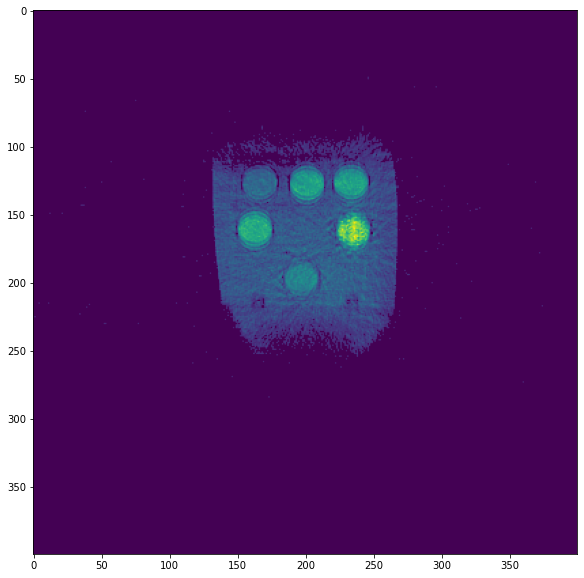

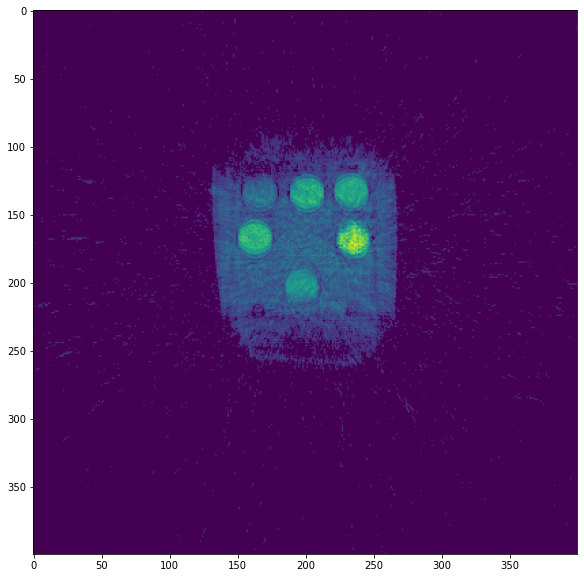

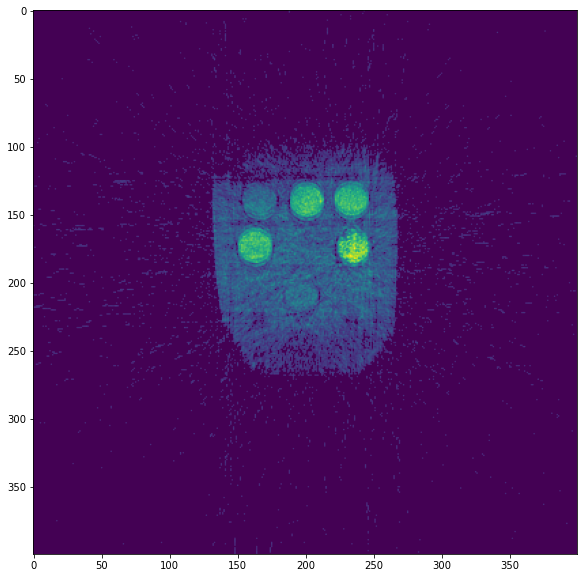

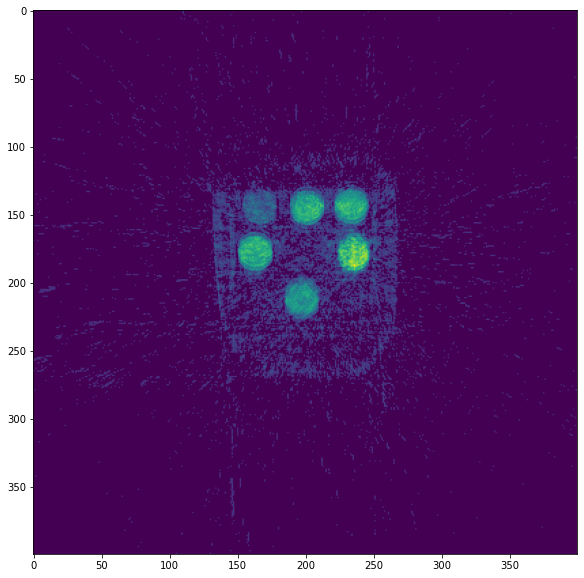

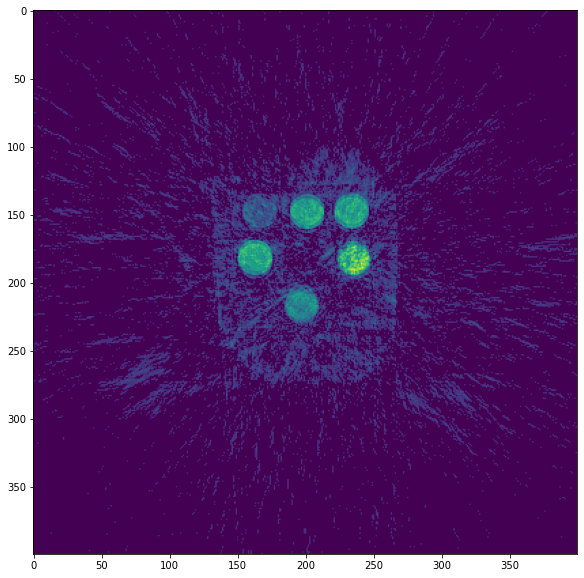

In [14]:
%matplotlib inline
from skimage.restoration import denoise_tv_chambolle

for j in dico_volume.keys():
    plt.figure(figsize=(10,10))
    #plt.imshow(denoise_tv_chambolle(np.abs((dico_mask[j]*dico_volume[j])[int(nb_slices/2),:,:]),weight=0.00001))
    plt.imshow(np.abs((dico_mask[j][int(nb_slices/2),:,:]*dico_volume[j][int(nb_slices/2),:,:])))

    
#plt.figure(figsize=(10,10))
#plt.imshow(np.abs(volume[int(nb_slices/2),:,:]))

In [15]:
import cv2
import numpy as np

index_ref=0

dico_homographies={}

for index_to_align in dico_volume.keys():
    dico_homographies[index_to_align]={}
    for sl in range(nb_slices):

        # Open the image files.
        array_to_align = np.abs(dico_mask[index_to_align][sl]*dico_volume[index_to_align][sl])
        array_ref = np.abs(dico_mask[index_ref][sl]*dico_volume[index_ref][sl])

        array_to_align  = array_to_align/(array_to_align).max()
        array_ref  = array_ref/(array_ref).max()


        uint_img_to_align = np.array(array_to_align*255).astype('uint8')
        uint_img_ref = np.array(array_ref*255).astype('uint8')


        #img1_color = np.abs() # Image to be aligned.
        #img2_color = np.abs(dico_volume[1][int(nb_slices/2)])

        # Convert to grayscale.
        img1_color = cv2.cvtColor(uint_img_to_align, cv2.COLOR_GRAY2BGR)
        img2_color = cv2.cvtColor(uint_img_ref, cv2.COLOR_GRAY2BGR)

        img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

        # Find size of image1
        sz = img1.shape

        # Define the motion model
        warp_mode = cv2.MOTION_TRANSLATION

        # Define 2x3 or 3x3 matrices and initialize the matrix to identity
        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            warp_matrix = np.eye(3, 3, dtype=np.float32)
        else :
            warp_matrix = np.eye(2, 3, dtype=np.float32)

        # Specify the number of iterations.
        number_of_iterations = 5000;

        # Specify the threshold of the increment
        # in the correlation coefficient between two iterations
        termination_eps = 1e-10;

        # Define termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

        # Run the ECC algorithm. The results are stored in warp_matrix.
        (cc, warp_matrix) = cv2.findTransformECC (img2,img1,warp_matrix, warp_mode, criteria)

        #if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        #    transformed_img = cv2.warpPerspective (img1, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        #else :
        # Use warpAffine for Translation, Euclidean and Affine
        #    transformed_img = cv2.warpAffine(img1, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        
        dico_homographies[index_to_align][sl]=warp_matrix



In [86]:
dico_homographies

{0: {0: array([[ 1.000000e+00,  0.000000e+00,  2.314894e-16],
         [ 0.000000e+00,  1.000000e+00, -4.144755e-16]], dtype=float32),
  1: array([[ 1.000000e+00,  0.000000e+00, -8.823511e-15],
         [ 0.000000e+00,  1.000000e+00, -8.498197e-15]], dtype=float32),
  2: array([[1.0000000e+00, 0.0000000e+00, 2.8152313e-15],
         [0.0000000e+00, 1.0000000e+00, 5.3165727e-14]], dtype=float32),
  3: array([[ 1.0000000e+00,  0.0000000e+00, -9.2471476e-15],
         [ 0.0000000e+00,  1.0000000e+00,  7.8399005e-14]], dtype=float32),
  4: array([[ 1.000000e+00,  0.000000e+00, -1.702507e-10],
         [ 0.000000e+00,  1.000000e+00, -6.982639e-12]], dtype=float32),
  5: array([[ 1.0000000e+00,  0.0000000e+00, -7.8354325e-15],
         [ 0.0000000e+00,  1.0000000e+00,  3.0549432e-14]], dtype=float32),
  6: array([[ 1.0000000e+00,  0.0000000e+00,  1.4775312e-14],
         [ 0.0000000e+00,  1.0000000e+00, -4.7764046e-14]], dtype=float32),
  7: array([[ 1.0000000e+00,  0.0000000e+00, -7.6960075

<IPython.core.display.Javascript object>


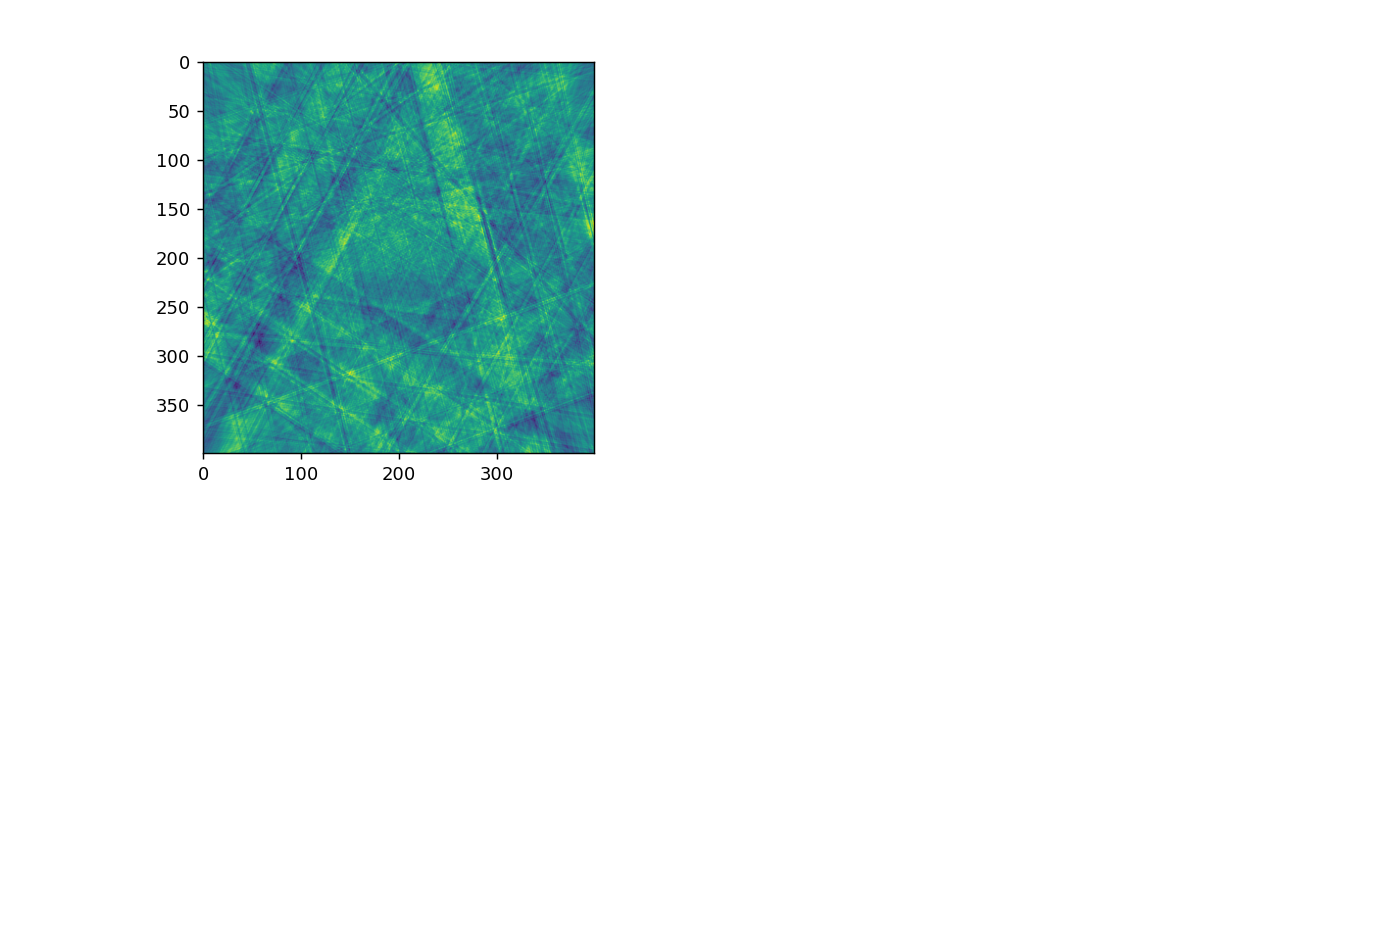

In [83]:
%matplotlib notebook
animate_images([img2,transformed_img],interval=1000)

In [128]:
dico_kdata_retained_registration={}
dico_volumes_corrected={}
for j,g in tqdm(enumerate(groups)):
    retained_nav_spokes_index = np.argwhere(g).flatten()
    spoke_groups = np.argmin(np.abs(np.arange(0, nb_segments * nb_part, 1).reshape(-1, 1) - np.arange(0, nb_segments * nb_part,nb_segments / nb_gating_spokes).reshape(1,-1)),axis=-1)
    included_spokes = np.array([s in retained_nav_spokes_index for s in spoke_groups])
    included_spokes[::int(nb_segments/nb_gating_spokes)]=False
    print("Filtering KData for movement...")
    kdata_retained_final_list = []
    for i in (range(nb_channels)):
        kdata_retained_final, traj_retained_final, retained_timesteps = correct_mvt_kdata(
            kdata_all_channels_all_slices[i].reshape(nb_segments, -1), radial_traj, included_spokes, ntimesteps, density_adj=True,log=False)
        kdata_retained_final_list.append(kdata_retained_final)
    
    dico_kdata_retained_registration[j]=(kdata_retained_final_list,traj_retained_final,retained_timesteps)
    
    radial_traj_3D_corrected=Radial3D(total_nspokes=nb_allspokes,undersampling_factor=undersampling_factor,npoint=npoint,nb_slices=nb_slices,incoherent=incoherent,mode=mode)
    radial_traj_3D_corrected.traj_for_reconstruction=traj_retained_final

    volumes_corrected = simulate_radial_undersampled_images_multi(kdata_retained_final_list,radial_traj_3D_corrected,image_size,b1=b1_full,ntimesteps=len(retained_timesteps),density_adj=False,useGPU=False,normalize_kdata=False,memmap_file=None,light_memory_usage=True,is_theta_z_adjusted=True,normalize_volumes=False)
    
    print("Re-registering corrected volumes")
    for ts in tqdm(range(volumes_corrected.shape[0])):
        for sl in range(volumes_corrected.shape[1]):
            volumes_corrected[ts,sl,:,:]=scipy.ndimage.affine_transform(volumes_corrected[ts,sl,:,:].T,dico_homographies[j][sl]).T
    dico_volumes_corrected[j]=copy(volumes_corrected)
    

0it [00:00, ?it/s]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(

100%|████████████████████████████████████████| 175/175 [00:00<00:00, 876.17it/s]
/Users/constantinslioussarenko/PythonGitRepositories/MyoMap/mrf-sim/utils_mrf.py:2661: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return kdata_retained_final,traj_retained_final,retained_timesteps
/Users/constantinslioussarenko/PythonGitRepositories/MyoMap/mrf-sim/utils_mrf.py:2662: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

(39200, 3)
float32
Performing NUFFT
(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]

1it [00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(43200, 3)
(43200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

2it [00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32000, 3)
(32000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

3it [00:00,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28000, 3)
(28000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

4it [00:01,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32000, 3)
(32000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

5it [00:01,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(24000, 3)
(24000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

6it [00:01,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

7it [00:02,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

8it [00:02,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(20000, 3)
(20000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

9it [00:02,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

10it [00:03,  3.52it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

11it [00:03,  3.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

12it [00:03,  3.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

13it [00:03,  3.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

14it [00:04,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

15it [00:04,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40000, 3)
(40000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

16it [00:04,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

17it [00:05,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

18it [00:05,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

19it [00:05,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(47200, 3)
(47200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]

20it [00:06,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]

21it [00:06,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]

22it [00:06,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40800, 3)
(40800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

23it [00:07,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

24it [00:07,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

25it [00:07,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

26it [00:07,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28800, 3)
(28800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

27it [00:08,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

28it [00:08,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

29it [00:08,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40000, 3)
(40000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

30it [00:09,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

31it [00:09,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

32it [00:09,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

33it [00:10,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]

34it [00:10,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

35it [00:10,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

36it [00:11,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(52800, 3)
(52800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

37it [00:11,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(64000, 3)
(64000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]

38it [00:11,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(56000, 3)
(56000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

39it [00:12,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(64000, 3)
(64000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]

40it [00:12,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(56000, 3)
(56000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

41it [00:12,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

42it [00:13,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

43it [00:13,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

44it [00:13,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]

45it [00:14,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

46it [00:14,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

47it [00:14,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

48it [00:15,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

49it [00:15,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

50it [00:15,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(52000, 3)
(52000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

51it [00:16,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]

52it [00:16,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]

53it [00:16,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]

54it [00:17,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]

55it [00:17,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

56it [00:17,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

57it [00:18,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

58it [00:18,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]

59it [00:18,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]

60it [00:19,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

61it [00:19,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

62it [00:19,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]

63it [00:20,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

64it [00:20,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(45600, 3)
(45600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]

65it [00:20,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]

66it [00:21,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

67it [00:21,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

68it [00:21,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(43200, 3)
(43200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

69it [00:22,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

70it [00:22,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

71it [00:22,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40000, 3)
(40000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

72it [00:23,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]

73it [00:23,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

74it [00:23,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

75it [00:24,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(43200, 3)
(43200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]

76it [00:24,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

77it [00:24,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]

78it [00:25,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40000, 3)
(40000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]

79it [00:25,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

80it [00:25,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

81it [00:26,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

82it [00:26,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(47200, 3)
(47200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]

83it [00:26,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]

84it [00:27,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]

85it [00:27,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]

86it [00:28,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]

87it [00:28,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]

88it [00:28,  2.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]

89it [00:29,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

90it [00:29,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

91it [00:29,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

92it [00:30,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]

93it [00:30,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]

94it [00:31,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]

95it [00:31,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]

96it [00:31,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(53600, 3)
(53600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]

97it [00:32,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

98it [00:32,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

99it [00:32,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]

100it [00:33,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

101it [00:33,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]

102it [00:33,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]

103it [00:34,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

104it [00:34,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

105it [00:34,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

106it [00:35,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]

107it [00:35,  2.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

108it [00:36,  2.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

109it [00:36,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]

110it [00:36,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]

111it [00:37,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

112it [00:37,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

113it [00:37,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(52000, 3)
(52000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]

114it [00:38,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

115it [00:38,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

116it [00:38,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]

117it [00:39,  2.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

118it [00:39,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

119it [00:39,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

120it [00:40,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]

121it [00:40,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]

122it [00:41,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]

123it [00:41,  2.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]

124it [00:42,  2.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]

125it [00:42,  2.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]

126it [00:42,  2.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]

127it [00:43,  2.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]

128it [00:43,  2.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]

129it [00:44,  2.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

130it [00:44,  2.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]

131it [00:44,  2.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40800, 3)
(40800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]

132it [00:45,  2.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

133it [00:45,  2.60it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

134it [00:46,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40000, 3)
(40000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]

135it [00:46,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]

136it [00:46,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

137it [00:47,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

138it [00:47,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(43200, 3)
(43200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]

139it [00:47,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

140it [00:48,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]

141it [00:48,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(40000, 3)
(40000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]

142it [00:48,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

143it [00:49,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

144it [00:49,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

145it [00:49,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(47200, 3)
(47200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]

146it [00:50,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]

147it [00:50,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

148it [00:50,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]

149it [00:51,  2.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]

150it [00:51,  2.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

151it [00:52,  2.60it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]

152it [00:52,  2.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]

153it [00:52,  2.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]

154it [00:53,  2.59it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

155it [00:53,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]

156it [00:54,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]

157it [00:54,  2.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]

158it [00:54,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(57600, 3)
(57600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]

159it [00:55,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(53600, 3)
(53600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

160it [00:55,  2.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

161it [00:55,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

162it [00:56,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

163it [00:56,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

164it [00:56,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

165it [00:57,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]

166it [00:57,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]

167it [00:57,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

168it [00:58,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

169it [00:58,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(49600, 3)
(49600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]

170it [00:58,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]

171it [00:59,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

172it [00:59,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]

173it [01:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(46400, 3)
(46400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]

174it [01:00,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]

175it [01:00,  2.88it/s]

  0%|                                                   | 0/175 [00:00<?, ?it/s]

Re-registering corrected volumes



100%|█████████████████████████████████████████| 175/175 [01:51<00:00,  1.57it/s]
1it [03:00, 180.54s/it]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(

100%|████████████████████████████████████████| 175/175 [00:00<00:00, 964.25it/s]
/Users/constantinslioussarenko/PythonGitRepositories/MyoMap/mrf-sim/utils_mrf.py:2661: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return kdata_retained_final,traj_retained_final,retained_timesteps
/Users/constantinslioussarenko/PythonGitRepositories/MyoMap/mrf-sim/utils_mrf.py:2662: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

(50400, 3)
float32
Performing NUFFT
(50400, 3)
(50400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]

1it [00:00,  2.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(59200, 3)
(59200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]

2it [00:00,  2.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(70400, 3)
(70400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]

3it [00:01,  2.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(61600, 3)
(61600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]

4it [00:01,  2.50it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(70400, 3)
(70400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]

5it [00:02,  2.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(74400, 3)
(74400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]

6it [00:02,  2.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(76800, 3)
(76800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

7it [00:02,  2.58it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(67200, 3)
(67200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]

8it [00:03,  2.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(73600, 3)
(73600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]

9it [00:03,  2.66it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

10it [00:03,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

11it [00:04,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

12it [00:04,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

13it [00:04,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

14it [00:04,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

15it [00:05,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(48000, 3)
(48000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]

16it [00:05,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

17it [00:06,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

18it [00:06,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

19it [00:06,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(21600, 3)
(21600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

20it [00:06,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

21it [00:07,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

22it [00:07,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

23it [00:07,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

24it [00:08,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

25it [00:08,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]

26it [00:08,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

27it [00:09,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

28it [00:09,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]

29it [00:09,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(42400, 3)
(42400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

30it [00:10,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

31it [00:10,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

32it [00:10,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]

33it [00:11,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(21600, 3)
(21600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

34it [00:11,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]

35it [00:11,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]

36it [00:12,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

37it [00:12,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

38it [00:12,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

39it [00:13,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

40it [00:13,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(23200, 3)
(23200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

41it [00:13,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

42it [00:14,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

43it [00:14,  3.49it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(26400, 3)
(26400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

44it [00:14,  3.52it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32000, 3)
(32000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

45it [00:14,  3.39it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28000, 3)
(28000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

46it [00:15,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32000, 3)
(32000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

47it [00:15,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(24000, 3)
(24000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

48it [00:15,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

49it [00:16,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

50it [00:16,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(20000, 3)
(20000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

51it [00:16,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

52it [00:16,  3.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

53it [00:17,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

54it [00:17,  3.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(37600, 3)
(37600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

55it [00:17,  3.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

56it [00:18,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

57it [00:18,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(41600, 3)
(41600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

58it [00:18,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

59it [00:19,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

60it [00:19,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

61it [00:19,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(35200, 3)
(35200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

62it [00:19,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

63it [00:20,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

64it [00:20,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(45600, 3)
(45600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

65it [00:20,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

66it [00:21,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

67it [00:21,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

68it [00:21,  3.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

69it [00:22,  3.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

70it [00:22,  3.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

71it [00:22,  3.52it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

72it [00:22,  3.49it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

73it [00:23,  3.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

74it [00:23,  3.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

75it [00:23,  3.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

76it [00:24,  3.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

77it [00:24,  3.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]

78it [00:24,  3.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

79it [00:24,  3.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

80it [00:25,  3.50it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

81it [00:25,  3.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

82it [00:25,  3.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(47200, 3)
(47200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

83it [00:26,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

84it [00:26,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]

85it [00:26,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(41600, 3)
(41600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]

86it [00:27,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

87it [00:27,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

88it [00:27,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

89it [00:27,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(35200, 3)
(35200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

90it [00:28,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

91it [00:28,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

92it [00:28,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(42400, 3)
(42400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

93it [00:29,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

94it [00:29,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

95it [00:29,  3.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

96it [00:30,  3.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(37600, 3)
(37600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

97it [00:30,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

98it [00:30,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

99it [00:30,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

100it [00:31,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

101it [00:31,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

102it [00:31,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

103it [00:32,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32800, 3)
(32800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

104it [00:32,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

105it [00:32,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

106it [00:33,  3.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28000, 3)
(28000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

107it [00:33,  3.45it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]

108it [00:33,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

109it [00:34,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

110it [00:34,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

111it [00:34,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]

112it [00:35,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

113it [00:35,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(42400, 3)
(42400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]

114it [00:35,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

115it [00:36,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

116it [00:36,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

117it [00:36,  3.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(37600, 3)
(37600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

118it [00:36,  3.34it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]

119it [00:37,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]

120it [00:37,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(41600, 3)
(41600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]

121it [00:37,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

122it [00:38,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

123it [00:38,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

124it [00:38,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(35200, 3)
(35200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

125it [00:39,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

126it [00:39,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]

127it [00:39,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(45600, 3)
(45600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]

128it [00:40,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

129it [00:40,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

130it [00:40,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

131it [00:41,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

132it [00:41,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

133it [00:41,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

134it [00:41,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

135it [00:42,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]

136it [00:42,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

137it [00:42,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

138it [00:43,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

139it [00:43,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

140it [00:43,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

141it [00:44,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(48000, 3)
(48000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

142it [00:44,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

143it [00:44,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

144it [00:45,  3.41it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

145it [00:45,  3.39it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(37600, 3)
(37600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

146it [00:45,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

147it [00:45,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

148it [00:46,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(41600, 3)
(41600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

149it [00:46,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]

150it [00:46,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

151it [00:47,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

152it [00:47,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(35200, 3)
(35200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

153it [00:47,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

154it [00:48,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]

155it [00:48,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(42400, 3)
(42400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

156it [00:48,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

157it [00:49,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

158it [00:49,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

159it [00:49,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(37600, 3)
(37600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

160it [00:50,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

161it [00:50,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

162it [00:50,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]

163it [00:51,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]

164it [00:51,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]

165it [00:51,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]

166it [00:52,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32800, 3)
(32800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

167it [00:52,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

168it [00:52,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

169it [00:53,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28000, 3)
(28000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

170it [00:53,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

171it [00:53,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

172it [00:54,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

173it [00:54,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(48800, 3)
(48800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]

174it [00:54,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(51200, 3)
(51200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

175it [00:55,  3.17it/s]

  0%|                                                   | 0/175 [00:00<?, ?it/s]

Re-registering corrected volumes



100%|█████████████████████████████████████████| 175/175 [01:49<00:00,  1.59it/s]
2it [05:57, 178.18s/it]

Filtering KData for movement...


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(

100%|███████████████████████████████████████| 157/157 [00:00<00:00, 2428.72it/s]
/Users/constantinslioussarenko/PythonGitRepositories/MyoMap/mrf-sim/utils_mrf.py:2661: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return kdata_retained_final,traj_retained_final,retained_timesteps
/Users/constantinslioussarenko/PythonGitRepositories/MyoMap/mrf-sim/utils_mrf.py:2662: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

(4000, 3)
float32
Performing NUFFT
(4000, 3)
(4000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

1it [00:00,  3.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(6400, 3)
(6400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

2it [00:00,  3.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(5600, 3)
(5600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

3it [00:00,  3.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8800, 3)
(8800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

4it [00:01,  3.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]

5it [00:01,  4.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

6it [00:01,  3.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]

7it [00:01,  4.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(17600, 3)
(17600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

8it [00:02,  3.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

9it [00:02,  3.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

10it [00:02,  3.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(14400, 3)
(14400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

11it [00:02,  3.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

12it [00:03,  3.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

13it [00:03,  3.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

14it [00:03,  3.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

15it [00:03,  3.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(38400, 3)
(38400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

16it [00:04,  3.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(33600, 3)
(33600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

17it [00:04,  3.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

18it [00:04,  3.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

19it [00:05,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(39200, 3)
(39200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

20it [00:05,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(44800, 3)
(44800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

21it [00:05,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28800, 3)
(28800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

22it [00:06,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

23it [00:06,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

24it [00:06,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(20000, 3)
(20000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

25it [00:06,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

26it [00:07,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

27it [00:07,  3.55it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

28it [00:07,  3.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(29600, 3)
(29600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

29it [00:08,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32000, 3)
(32000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

30it [00:08,  3.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28000, 3)
(28000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

31it [00:08,  3.49it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(30400, 3)
(30400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

32it [00:08,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

33it [00:09,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

34it [00:09,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

35it [00:09,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(23200, 3)
(23200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

36it [00:10,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

37it [00:10,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

38it [00:10,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(24800, 3)
(24800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

39it [00:11,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

40it [00:11,  3.39it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

41it [00:11,  3.41it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

42it [00:11,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(27200, 3)
(27200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

43it [00:12,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(32000, 3)
(32000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

44it [00:12,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(28000, 3)
(28000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

45it [00:12,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(30400, 3)
(30400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

46it [00:13,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

47it [00:13,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]

48it [00:13,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]

49it [00:14,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(15200, 3)
(15200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]

50it [00:14,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

51it [00:15,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

52it [00:15,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(14400, 3)
(14400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

53it [00:15,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

54it [00:16,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

55it [00:16,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

56it [00:16,  3.34it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(17600, 3)
(17600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]

57it [00:16,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

58it [00:17,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

59it [00:17,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

60it [00:17,  3.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

61it [00:18,  3.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

62it [00:18,  3.41it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

63it [00:18,  3.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

64it [00:18,  3.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

65it [00:19,  3.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

66it [00:19,  3.50it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

67it [00:19,  3.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

68it [00:20,  3.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

69it [00:20,  3.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

70it [00:20,  3.52it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

71it [00:20,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(14400, 3)
(14400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

72it [00:21,  3.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

73it [00:21,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

74it [00:21,  3.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

75it [00:22,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(17600, 3)
(17600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

76it [00:22,  3.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]

77it [00:22,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]

78it [00:23,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(13600, 3)
(13600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]

79it [00:23,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]

80it [00:23,  2.60it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

81it [00:24,  2.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]

82it [00:24,  2.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]

83it [00:25,  2.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(6400, 3)
(6400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

84it [00:25,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(5600, 3)
(5600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

85it [00:25,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

86it [00:25,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

87it [00:26,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]

88it [00:26,  2.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]

89it [00:27,  2.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(23200, 3)
(23200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

90it [00:27,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

91it [00:27,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

92it [00:28,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(24800, 3)
(24800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

93it [00:28,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]

94it [00:28,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

95it [00:29,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

96it [00:29,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]

97it [00:29,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(6400, 3)
(6400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

98it [00:30,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(5600, 3)
(5600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

99it [00:30,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

100it [00:30,  3.41it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

101it [00:30,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

102it [00:31,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

103it [00:31,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(15200, 3)
(15200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

104it [00:31,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

105it [00:32,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

106it [00:32,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(14400, 3)
(14400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

107it [00:32,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

108it [00:33,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]

109it [00:33,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

110it [00:33,  3.41it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(17600, 3)
(17600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

111it [00:33,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

112it [00:34,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

113it [00:34,  3.34it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12000, 3)
(12000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

114it [00:34,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(6400, 3)
(6400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

115it [00:35,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(5600, 3)
(5600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

116it [00:35,  3.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(6400, 3)
(6400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

117it [00:35,  3.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(10400, 3)
(10400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

118it [00:35,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

119it [00:36,  3.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

120it [00:36,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

121it [00:36,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

122it [00:37,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

123it [00:37,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

124it [00:37,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(14400, 3)
(14400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

125it [00:38,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

126it [00:38,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

127it [00:38,  3.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

128it [00:38,  3.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(17600, 3)
(17600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

129it [00:39,  3.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

130it [00:39,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

131it [00:39,  3.55it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(14400, 3)
(14400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]

132it [00:40,  3.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

133it [00:40,  3.52it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

134it [00:40,  3.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

135it [00:40,  3.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(17600, 3)
(17600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]

136it [00:41,  3.45it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(12800, 3)
(12800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

137it [00:41,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

138it [00:41,  3.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(13600, 3)
(13600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

139it [00:42,  3.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]

140it [00:42,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

141it [00:42,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

142it [00:43,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(11200, 3)
(11200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]

143it [00:43,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(6400, 3)
(6400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

144it [00:43,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(5600, 3)
(5600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

145it [00:43,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(8000, 3)
(8000,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

146it [00:44,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

147it [00:44,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

148it [00:44,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

149it [00:45,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(23200, 3)
(23200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

150it [00:45,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(25600, 3)
(25600,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

151it [00:45,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(22400, 3)
(22400,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

152it [00:46,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(24800, 3)
(24800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

153it [00:46,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]

154it [00:46,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(16800, 3)
(16800,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

155it [00:47,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(19200, 3)
(19200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

156it [00:47,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

(7200, 3)
(7200,)




100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

157it [00:47,  3.29it/s]

  0%|                                                   | 0/157 [00:00<?, ?it/s]

Re-registering corrected volumes



100%|█████████████████████████████████████████| 157/157 [01:35<00:00,  1.64it/s]
3it [08:24, 168.18s/it]


In [129]:
volumes_corrected_final=np.zeros((ntimesteps,nb_slices,int(npoint/2),int(npoint/2)),dtype=volumes_corrected.dtype)

In [134]:
counts=np.zeros(ntimesteps)

In [ ]:
for ts in range(ntimesteps):
    count=0
    for j in dico_kdata_retained_registration.keys():
        if ts in dico_kdata_retained_registration[j][2]:
            volumes_corrected_final[ts]+=dico_volumes_corrected[j][ts]
            count+=1
    volumes_corrected_final[ts]/=count

In [130]:
np.save("volumes_corrected_final.npy",volumes_corrected_final)

(175, 16, 400, 400)

In [133]:
dico_kdata_retained_registration[0][2]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174]

In [131]:
help(np.save)

Help on function save in module numpy:

save(file, arr, allow_pickle=True, fix_imports=True)
    Save an array to a binary file in NumPy ``.npy`` format.
    
    Parameters
    ----------
    file : file, str, or pathlib.Path
        File or filename to which the data is saved.  If file is a file-object,
        then the filename is unchanged.  If file is a string or Path, a ``.npy``
        extension will be appended to the filename if it does not already
        have one.
    arr : array_like
        Array data to be saved.
    allow_pickle : bool, optional
        Allow saving object arrays using Python pickles. Reasons for disallowing
        pickles include security (loading pickled data can execute arbitrary
        code) and portability (pickled objects may not be loadable on different
        Python installations, for example if the stored objects require libraries
        that are not available, and not all pickled data is compatible between
        Python 2 and Python 3).
  

In [ ]:
volumes_corrected_final=np.mean(np.array(dico_volumes_corrected.values()),axis=0)

In [118]:
import scipy
dico_homographies

{0: {0: array([[ 1.000000e+00,  0.000000e+00,  2.314894e-16],
         [ 0.000000e+00,  1.000000e+00, -4.144755e-16]], dtype=float32),
  1: array([[ 1.000000e+00,  0.000000e+00, -8.823511e-15],
         [ 0.000000e+00,  1.000000e+00, -8.498197e-15]], dtype=float32),
  2: array([[1.0000000e+00, 0.0000000e+00, 2.8152313e-15],
         [0.0000000e+00, 1.0000000e+00, 5.3165727e-14]], dtype=float32),
  3: array([[ 1.0000000e+00,  0.0000000e+00, -9.2471476e-15],
         [ 0.0000000e+00,  1.0000000e+00,  7.8399005e-14]], dtype=float32),
  4: array([[ 1.000000e+00,  0.000000e+00, -1.702507e-10],
         [ 0.000000e+00,  1.000000e+00, -6.982639e-12]], dtype=float32),
  5: array([[ 1.0000000e+00,  0.0000000e+00, -7.8354325e-15],
         [ 0.0000000e+00,  1.0000000e+00,  3.0549432e-14]], dtype=float32),
  6: array([[ 1.0000000e+00,  0.0000000e+00,  1.4775312e-14],
         [ 0.0000000e+00,  1.0000000e+00, -4.7764046e-14]], dtype=float32),
  7: array([[ 1.0000000e+00,  0.0000000e+00, -7.6960075

<IPython.core.display.Javascript object>


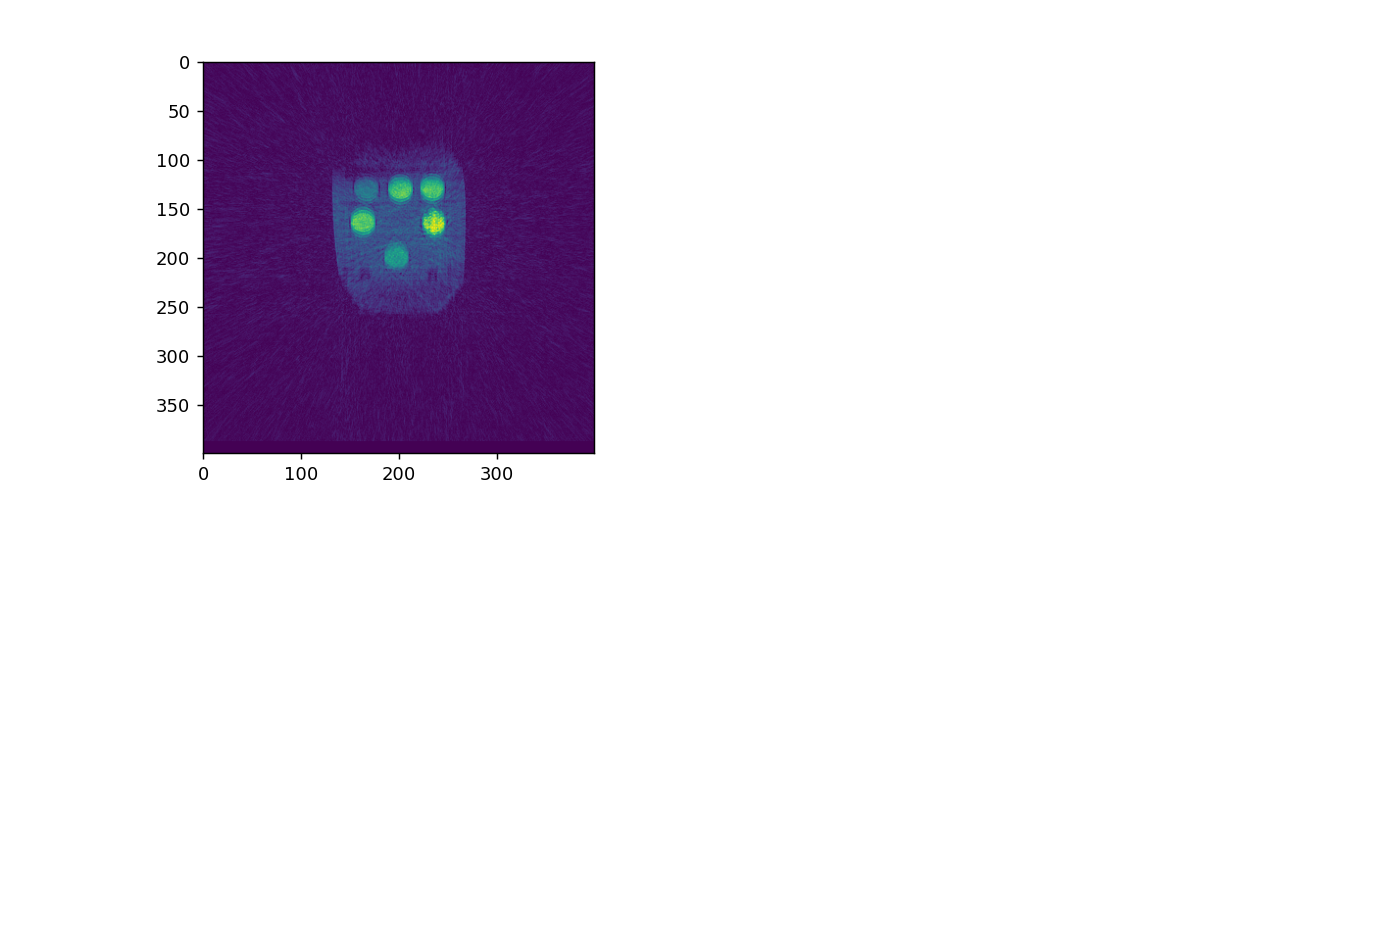

In [125]:
sl=int(nb_slices/2)

animate_images([scipy.ndimage.affine_transform(np.abs(dico_volume[1][sl].T),dico_homographies[1][sl]).T,np.abs(dico_volume[0][sl])])
                                               
                                               

<IPython.core.display.Javascript object>


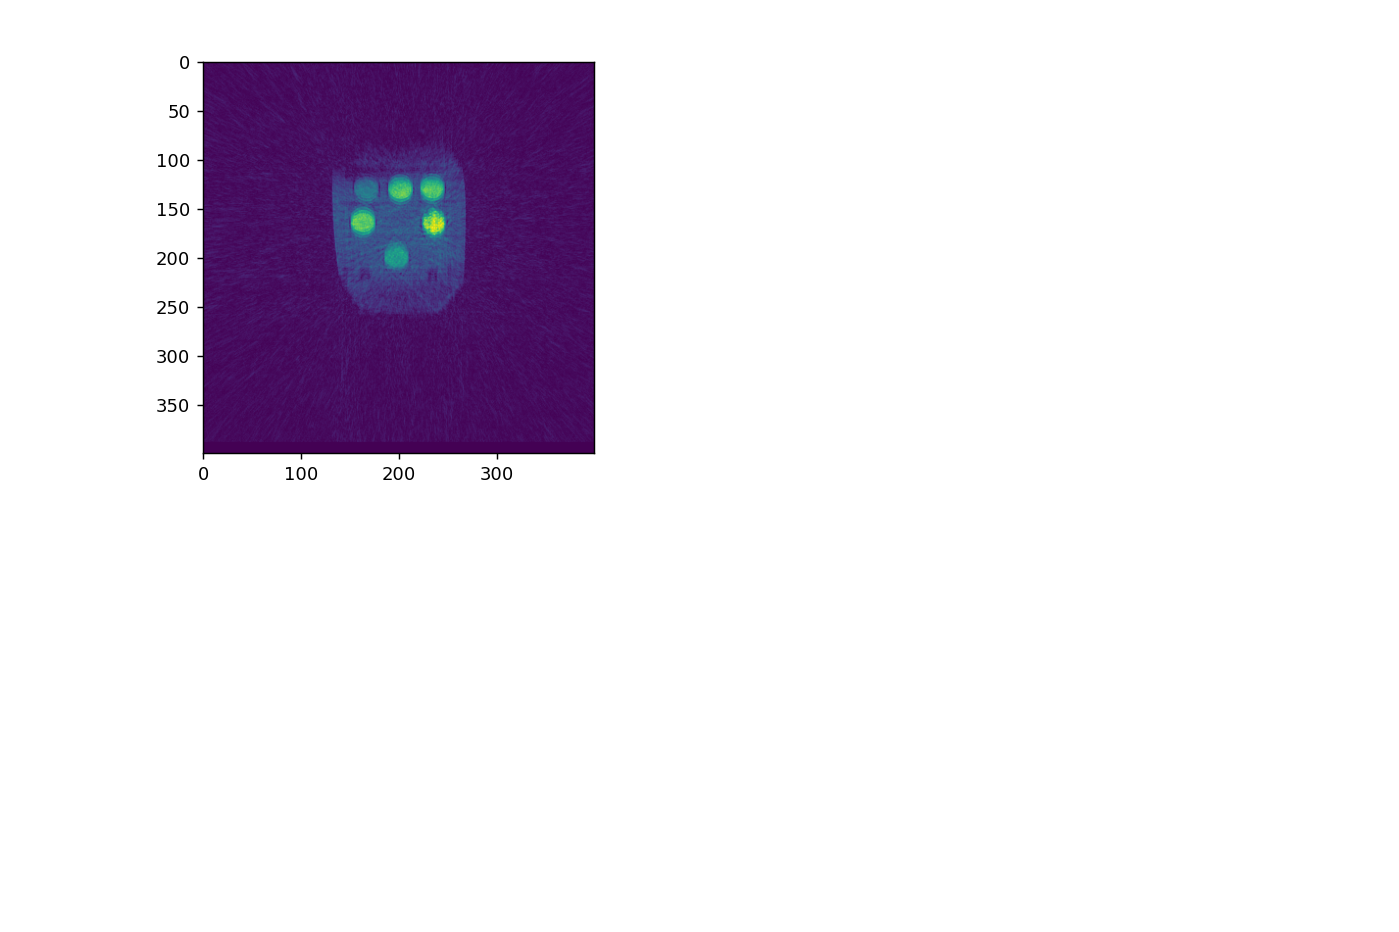

In [113]:
animate_images([cv2.warpAffine(np.abs(dico_volume[1][sl]), dico_homographies[1][sl], (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP),np.abs(dico_volume[0][sl])])
         

<IPython.core.display.Javascript object>


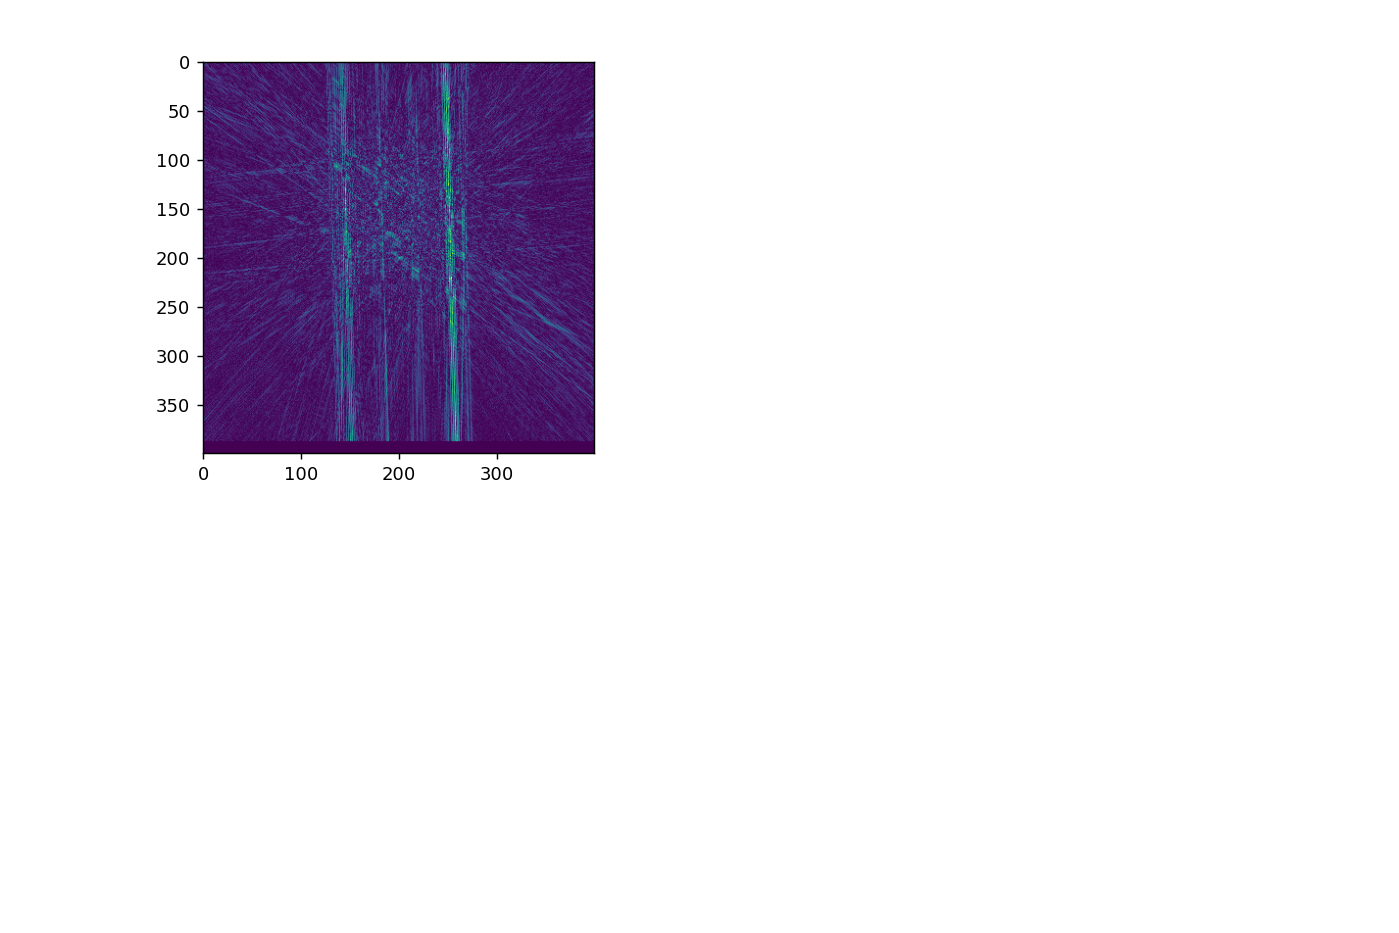

In [126]:
%matplotlib notebook
animate_images([np.real(scipy.ndimage.affine_transform(volumes_corrected[10,sl,:,:].T,dico_homographies[1][sl])).T,np.real(volumes_corrected[10,sl,:,:])])

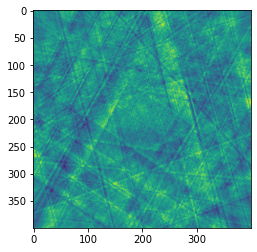

In [106]:
%matplotlib inline
plt.imshow(np.real(volumes_corrected[0,sl,:,:]))

In [101]:
volumes_corrected.shape

(175, 16, 400, 400)

In [91]:
img1.dtype

dtype('uint8')

In [93]:
help(cv2.warpAffine)

Help on built-in function warpAffine:

warpAffine(...)
    warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst
    .   @brief Applies an affine transformation to an image.
    .   
    .   The function warpAffine transforms the source image using the specified matrix:
    .   
    .   \f[\texttt{dst} (x,y) =  \texttt{src} ( \texttt{M} _{11} x +  \texttt{M} _{12} y +  \texttt{M} _{13}, \texttt{M} _{21} x +  \texttt{M} _{22} y +  \texttt{M} _{23})\f]
    .   
    .   when the flag #WARP_INVERSE_MAP is set. Otherwise, the transformation is first inverted
    .   with #invertAffineTransform and then put in the formula above instead of M. The function cannot
    .   operate in-place.
    .   
    .   @param src input image.
    .   @param dst output image that has the size dsize and the same type as src .
    .   @param M \f$2\times 3\f$ transformation matrix.
    .   @param dsize size of the output image.
    .   @param flags combination of interpolation methods (

In [ ]:
dico_kdata_retained={}
dico_volume_corrected={}